# 模型训练
本文档主要是结合了两个例程，实现迁移学习。base_model使用的是mobilenet_v2模型，在其顶层自定义输入层Input(96,96,3)。在base_model的底层加入GlobalAveragePooling2D,Dropout,Dense。并最终连接output层输出结果。
在训练的过程中，base_model模型参数将会被冻结，或者以极低的学习率进行模型训练。
需要注意的是，在模型训练的过程中，每次编译模型都会让模型进入冻结状态。

## 1、先导入相关库文件

In [1]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [2]:
%load_ext tensorboard

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds
import datetime

In [4]:
print(tf.__version__)
print(tf.test.is_gpu_available())
tf.config.list_physical_devices('GPU')

2.6.2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Set the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 2、数据集的创建

In [6]:
import pathlib
data_dir = "C:\\dataset\\teeth_demo"
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*/*/*.png')))
print(image_count)

24090


In [8]:
PATH = data_dir

train_dir = os.path.join(PATH, 'train_open_close')
validation_dir = os.path.join(PATH, 'validation_open')

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (128, 128)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            color_mode='grayscale',
                                                            )

# color_mode='grayscale'

Found 21500 files belonging to 16 classes.


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='grayscale',
                                                                 )

Found 890 files belonging to 16 classes.


显示训练集的前九个图像与标签

In [10]:
train_dataset.class_names

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16']

In [11]:
validation_dataset.class_names

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16']

(64, 128, 128, 1)
(64,)


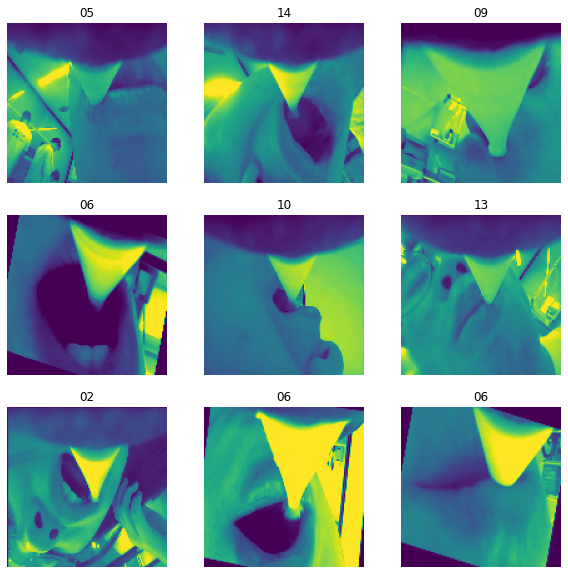

In [12]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

由于原始数据集不包含测试集，因此您需要创建一个。为此，使用 `tf.data.experimental.cardinality` 确定验证集中有多少批次的数据，然后将其中的 20% 移至测试集。

In [13]:
#val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(val_batches // 5)
#validation_dataset = validation_dataset.skip(val_batches // 5)

#print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
#print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

### 配置数据集以提高性能

使用缓冲预提取从磁盘加载图像，以免造成 I/O 阻塞。

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 从预训练卷积网络创建基础模型
通过指定 **include_top=False** 参数，可以加载不包括顶部分类层的网络


In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE,                                              
                                               include_top=False,
                                               weights='imagenet', #'imagenet'
                                               alpha=0.25,)  #0.25

#weights='imagenet',
#.mobilenet_v2.MobileNetV2

## 在基础模型的基础上进行修改

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [17]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
# 单颜色通道
# inputs = keras.Input(shape=(96, 96, 1))
inputs = keras.Input(shape=(128, 128, 1))
x = keras.layers.Conv2D(3, (3, 3), padding='same')(inputs)


# RGB颜色通道
# inputs = keras.Input(shape=(224, 224, 3))
# x = inputs  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
# scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(17)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 3)       30        
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 17)                4369  

In [18]:
inputs

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'input_2')>

## 训练顶层

In [19]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch=0)

In [20]:
log_dir

'logs/fit/20230725-201941'

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
#'mae', 
#loss=keras.losses.BinaryCrossentropy(from_logits=True),

#optimizer=keras.optimizers.Adam(),

In [22]:
epochs_top = 2
epochs_all = 10

In [23]:
model.fit(train_dataset, epochs=epochs_top, validation_data=validation_dataset,callbacks=[tensorboard_callback])

Epoch 1/2
336/336 [==============================] - 14s 33ms/step - loss: 1.6090 - accuracy: 0.5056 - val_loss: 1.5788 - val_accuracy: 0.4764
Epoch 2/2
336/336 [==============================] - 11s 31ms/step - loss: 0.7640 - accuracy: 0.7600 - val_loss: 1.3856 - val_accuracy: 0.5416


## 对整个模型进行一轮微调

最后，解冻基础模型，并以较低的学习率端到端地训练整个模型。

重要的是，尽管基础模型变得可训练，但在构建模型过程中，由于我们在调用该模型时传递了 `training=False`，因此它仍在推断模式下运行。这意味着内部的批次归一化层不会更新其批次统计信息。如果它们更新了这些统计信息，则会破坏该模型到目前为止所学习的表示。

In [ ]:
# epochs_top = 10
# epochs_all = 20

In [24]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate  1e-5
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq='epoch')

model.fit(train_dataset, epochs=epochs_all, validation_data=validation_dataset,callbacks=[tensorboard_callback],initial_epoch=epochs_top)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 3)       30        
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 17)                4369  

### 保存模型

In [ ]:
model.save('saved_model/6_10_model_v4.1_acc_0.78')
#5_19_model_v3.4_top_1_all_2

In [ ]:
model = tf.keras.models.load_model('saved_model/6_10_model_v4.1_acc_0.78')
model.summary()
# model.fit(train_dataset, epochs=11, validation_data=validation_dataset,callbacks=[tensorboard_callback],initial_epoch=10)

## 针对目标摄像头的数据集，进行第二次训练


In [ ]:
base_model.trainable = False
model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)


In [ ]:
# base_model.trainable = True
# model.summary()

In [ ]:
PATH = 'D:\\TF_data\\5_9\\6_10_train'

train2_dataset_dir = os.path.join(PATH)
train2_dataset_dir = pathlib.Path(train2_dataset_dir)



train_dataset_2 = tf.keras.utils.image_dataset_from_directory(train2_dataset_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            color_mode='grayscale',
                                                            )

In [ ]:
PATH = 'D:\\TF_data\\5_9\\test_5_14'

validation_dir_2 = os.path.join(PATH)
validation_dir_2 = pathlib.Path(validation_dir_2)

validation_dataset_2 = tf.keras.utils.image_dataset_from_directory(validation_dir_2,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='grayscale',
                                                                 )

In [ ]:
model.fit(train_dataset_2, epochs=16, validation_data=validation_dataset_2,callbacks=[tensorboard_callback],initial_epoch=11)

### 解冻模型进行全局训练

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

In [ ]:
model.fit(train_dataset_2, epochs=15, validation_data=validation_dataset_2,callbacks=[tensorboard_callback],initial_epoch=11)

## 评估和预测

In [ ]:
PATH = 'D:\\TF_data\\5_9\\train_5_16'

test_dataset_2_dir = os.path.join(PATH)
test_dataset_2_dir = pathlib.Path(test_dataset_2_dir)


In [ ]:
test_dataset_2 = tf.keras.utils.image_dataset_from_directory(test_dataset_2_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            color_mode='grayscale',
                                                            )

In [ ]:
# model.get_weights()

In [ ]:
# model.inputs

In [ ]:
loss,  acc = model.evaluate(test_dataset_2)
print('Test accuracy :', acc)
# acc:0.5828

In [ ]:

image = tf.image.decode_image(tf.io.read_file('F:\\2023口腔项目检测项目推进\\1_3_数据集2\\validation\\11\\-png0000.png'),channels=1)
image = tf.image.resize(image,(96,96))
image = tf.expand_dims(image, axis=0)
tfhub_preds = model.predict(image)
tfhub_preds


## 导出模型

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(image_batch).batch(32).take(10):
    yield [input_value]

In [ ]:
# 随机生成的模型图进行量化操作
# def representative_dataset():
#     for _ in range(100):
#       data = np.random.rand(1, 128, 128, 3)
#       yield [data.astype(np.float32)]

In [ ]:
#emotion_model_tflite = tf.lite.Interpreter("23_3_28_no_quantize_models_128_0.25_v0.11_float32.tflite")	

In [ ]:
#np.random.rand(1, 128, 128, 3)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8 # or tf.uint8
tflite_quant_model = converter.convert()

In [ ]:
import numpy as np

In [ ]:
test_dataset = test_dataset_2.astype(np.uint8)
loss,  acc = tflite_quant_model.evaluate(test_dataset_2)
print('Test accuracy :', acc)

In [ ]:
open("D:\\TF_data\\5_9\\深度学习训练代码\\训练好的模型\\23_6_12_quantize_models_96_0.25_v4.2_0.84_acc_uint8.tflite", "wb").write(tflite_quant_model)

### 保存非量化原始模型

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("D:\\文档整理\\2023口腔项目检测项目推进\\1_9_PNG数据集\\23_1_14_no_quantize_models_128_0.25_v0.7_float32.tflite", "wb").write(tflite_model)

### tflie模型推理

In [ ]:
import tensorflow as tf
import numpy as np

加载TFlite模型

In [ ]:
emotion_model_tflite = tf.lite.Interpreter("23_5_14_quantize_models_96_0.25_v1.3_uint8.tflite")	

加载图片

In [ ]:
image = tf.image.decode_image(tf.io.read_file("D:\\TF_data\\5_9\\test_5_14\\01\\output\\01-007.png"),channels=1)
image = tf.image.resize(image,(96,96))
image = tf.expand_dims(image, axis=0)
# image

In [ ]:
# print(image.dtype)
image1= np.array(image)
image2= image1.astype(np.uint8)
# print(image2.dtype)
# image2

In [ ]:
emotion_model_tflite.allocate_tensors()  # 预先计划张量分配以优化推理
tflife_input_details = emotion_model_tflite.get_input_details()  # 获取输入节点的细节
tflife_output_details = emotion_model_tflite.get_output_details()  # 获取输出节点的细节

填入输入tensor

In [ ]:
emotion_model_tflite.set_tensor(tflife_input_details[0]['index'], image2)

运行推断

In [ ]:
emotion_model_tflite.invoke()

获取推断结果

In [ ]:
custom = emotion_model_tflite.get_tensor(tflife_output_details[0]['index'])
print(custom)